Importing all the required libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer
import numpy as np
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM,BatchNormalization
from keras.models import Sequential
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import keras
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical

First, we'll read the dataset and try to see what all coulumns are useful for us

In [2]:
data = pd.read_excel("flipkart_com-ecommerce_sample.xlsx")
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [85]:
data.shape

(20000, 15)

there are 15 columns and 20000 data points in total. </br>
For now,I'll try to create a model only using the description column as the data. If good results are not obtained, I'll try to use other features as well. </br>
Converting product category tree and description to a list.

In [86]:
category_tree = (data["product_category_tree"]).to_list()
product_descr = data["description"].to_list()



From the category tree, since we need to predict the primary category, I'll only extract the root category, eg -> Clothing from ["Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts"] and discard the rest. </br>


Now Creating a list of tuple pairs, having product description and the primary category as pairs. Will use split function to extract the root category. 

In [87]:
list_pair=[]
for x in range(len(category_tree)):
    list_pair.append((product_descr[x],category_tree[x].split(">>")[0][2:-1]))


Moving ahead, we need to see how many target categories are available. If very less data is available for any product category, data for that category will have to be discarded. </br>
So now, I'll create a dictionary, and count the number of data points for each category.

In [89]:
dic = {}
for descr,category in list_pair:
    if category in dic.keys():
        dic[category]+=1
    else:
        dic[category] = 1

Sorting dictionary in descending order, to check number of data points for each category.

In [94]:
category_dict = dict(sorted(dic.items(), key=lambda item: item[1],reverse = True))
print(category_dict)

{'Clothing': 6198, 'Jewellery': 3531, 'Footwear': 1227, 'Mobiles & Accessories': 1099, 'Automotive': 1012, 'Home Decor & Festive Needs': 929, 'Beauty and Personal Care': 710, 'Home Furnishing': 700, 'Kitchen & Dining': 647, 'Computers': 578, 'Watches': 530, 'Baby Care': 483, 'Tools & Hardware': 391, 'Toys & School Supplies': 330, 'Pens & Stationery': 313, 'Bags, Wallets & Belts': 265, 'Furniture': 180, 'Sports & Fitness': 166, 'Cameras & Accessories': 82, 'Home Improvement': 81, 'Health & Personal Care Appliances': 43, 'Gaming': 35, 'Sunglasses': 35, 'Pet Supplies': 30, 'Home & Kitchen': 24, 'Home Entertainment': 19, 'eBooks': 15, 'Eyewear': 10, 'Clovia Women\'s Full Coverage Bra"': 9, 'Vishudh Printed Women\'s Straight Kurta"': 8, 'Lilliput Top Baby Girl\'s  Combo"': 8, 'Olvin Aviator Sunglasses"': 7, 'Clovia Women\'s T-Shirt Bra"': 6, 'MASARA Solid Women\'s Straight Kurta"': 5, 'Sunglasses"': 5, 'Dressberry Gold Synthetic  Clutch"': 4, 'Pu-Good Women Flats"': 4, 'FEET FLOW Women Flat

In [95]:
len(category_dict)

266

We can see that in total there are 266 categories, but very less data is available for most of the categories. I felt that atleast 10 data points (0.05% of entire corpus) should be available for each category. Model would not be accurately be able to predict categories having less data points.</br> So, eliminating such categories below

In [9]:
tgt_categories=[]
for key in dic:
    if dic[key]>=10:
        tgt_categories.append(key)

In [10]:
len(tgt_categories)

28

As we can see above, now we have 28 product categories left. So now will keep only data points of these categories

In [11]:
final_list=[]
X_descr = []
y_category= []
for descr,category in list_pair:
    if category in tgt_categories:
        if(type(descr)!=float):
            X_descr.append(descr)
            y_category.append(category)

In [101]:
print(len(X_descr))
print(len(y_category))


19661
19661


Now we have 19961 data points left. We have discarded 339 data points due to insuffificient data. </br>
Now converting product categories into integers from 0-27

In [112]:
tgt_labels= []
for categ in y_category:
    for i in range(len(tgt_categories)):
        if categ==tgt_categories[i]:
            tgt_labels.append(i)

Splitting data into train and test sets using sklearn's train_test_split. Have used 80% data for training, and 20% for testing

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_descr, tgt_labels, test_size=0.2, random_state=42,shuffle=True)

Now we have the preprocessed datasets. </br>
For tokenising, I have used pretrain BERT Tokenizer from huggingface.</br>
Now tokenizing the dataset.

In [20]:
X_train_tokenized = []
X_test_tokenized = []
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
for elem in X_train:
       X_train_tokenized.append((tokenizer.tokenize(elem)))
        
for elem in X_test:
       X_test_tokenized.append((tokenizer.tokenize(elem)))


Creating a list of of all unique tokens after tokenizing.

In [31]:
tokens = []
for x in X_train_tok:
    for tok in x:
        tokens.append(tok)
tokens = list(set(tokens))


In [118]:
print(tokens[0:10])

['butterfly', 'formulated', '##kon', 'fl', '470', '##nt', 'middle', 'spells', '234', 'fountain']


Now, we'll create a dictionary having each unique element as the key, and an index value for each token

In [35]:
dic_tok = {}
for i in range(len(tokens)):
            dic_tok[tokens[i]] = i + 1

In [124]:
vocab_size = len(tokens)
print(vocab_size)

10244


In total, we have 10244 unique tokens from the training corpus

Further ahead, using 300 Dimension GloVe embeddings for the CNN model which will be used. So, getting GloVe embeddings ready

In [37]:
embeddings_index = dict()
f = open('/media/akshat/Data/MIDAS/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


Now, creating an embedding matrix having shape (vocab_size,300) (since we are using 300d embeddings) which will be the first layer of the CNN.

In [38]:
i=0
embedding_matrix = np.zeros((vocab_size, 300))

for word in dic_tok.keys():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        i+=1

Now, to feed the dataset into the sequential CNN model, we will encode the sentences. For this we'll be using the token dictionary we created for all unique tokens (dic_tok). Will replace each word by their respective value. </br>
We will also truncate and pad the sequences. All sentences having less than 100 tokens will be padded to 100, and sequences with more tokens will be truncated.

In [39]:
def encode(string):
        b = []
        for i in string:
            if i in dic_tok:
                b.append(dic_tok[i])
            else:
                continue
        if len(b) < 100:
            for i in range(100 - len(b)):
                b.append(0)
        elif len(b) >= 100:
            b=b[:100]
        return b

Calling the processed dataset as X_train_final and X_test_final

In [40]:
X_train_final = []
for x_to_encode in X_train_tokenized:
            X_train_final.append(encode(x_to_encode))
X_train_final = np.array(X_train_final)


In [41]:
X_test_final = []
for x_to_encode in X_test_tokenized:
            X_test_final.append(encode(x_to_encode))
X_test_final = np.array(X_test_final)

Also converting category_list to categorical arrays to input into the model

In [46]:
y_train_final = to_categorical(y_train, num_classes=len(tgt_categories))
y_test_final = to_categorical(y_test, num_classes=len(tgt_categories))

I have used a CNN model using the Keras Framework having an embedding layer, three Conv1D layers, 1 Dense layer and then a softmax layer for prediction. More details can be found in the README file

In [127]:


embedding_layer = Embedding(vocab_size+1, 300, weights=[embedding_matrix], input_length=100,
                                        trainable=True)
model = Sequential()

model.add(embedding_layer)

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(512, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(28, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_final, y_train_final, batch_size=16, epochs=15, verbose=1,validation_data = (X_test_final,y_test_final),shuffle = True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          3073500   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           115328    
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 256)           98560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 256)           1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 256)           0

KeyboardInterrupt: 

Now predicting on the test set using the trained model

In [806]:

y_pred = model.predict_classes(X_test_final)

/home/akshat/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Since class imblanace is very high, we will have to used weighted F1 scores to correctly justify the prediction results.

In [128]:

print("F1 Score : ",f1_score(y_test, y_pred , average="weighted"))

F1 Score :  0.25074529668923934


Overall an F1 score of 0.97 was obtained. From the score we can say that the model is working quite well.


Printing the classification report

In [811]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1210
           1       0.95      0.95      0.95        43
           2       1.00      1.00      1.00       270
           3       1.00      0.75      0.86        12
           4       0.85      0.84      0.85        62
           5       0.94      0.88      0.91        34
           6       0.92      0.93      0.93       133
           7       0.94      0.94      0.94        50
           8       0.96      0.99      0.97       177
           9       0.95      0.99      0.97       212
          10       0.97      0.91      0.94        81
          11       0.96      0.99      0.97       138
          12       0.96      0.82      0.89       108
          13       0.97      0.99      0.98       210
          14       1.00      0.99      1.00       106
          15       0.79      0.84      0.81        67
          16       1.00      1.00      1.00       700
          17       0.97    

Plotting train and test accuracies and losses

In [129]:

#history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [813]:
model.metrics_names

['loss', 'accuracy']

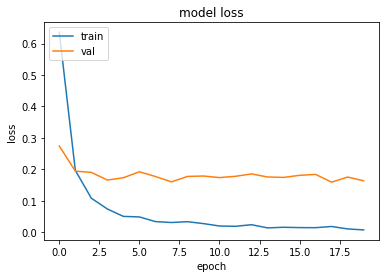

In [814]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()